# Import the training data

## Read the training data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import re

data = pd.read_pickle('data/global_train_data.pkl').sample(1000)
data = data.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
data = data.replace([np.inf, -np.inf], np.nan)

# Get X and y from data
y = data['TARGET'].values
X = data.drop(['TARGET', 'SK_ID_CURR'], axis=1)

# preprocessing steps
pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
X_prepro = pipe.fit_transform(X)

# Split in train and test
X_train, X_valid, y_train, y_valid = train_test_split(
    X_prepro, y, stratify=y, random_state=1)

print('Shape of X_train:', X_train.shape)
print('Shape of X_valid:', X_valid.shape)

Shape of X_train: (750, 795)
Shape of X_valid: (250, 795)


## Fit data with LGBM

In [2]:
%%time

import lightgbm as lgb
from sklearn.metrics import roc_auc_score

params = {'boosting_type': 'gbdt', 'objective': 'binary', 'max_depth': 18,
          'n_jobs': -1, 'num_leaves': 30, 'learning_rate': 0.02, 'n_estimators': 1600,
          'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.8,
          'subsample_freq': 1, 'colsample_bytree': 0.8,
          'reg_alpha': 80, 'reg_lambda': 20,
          'min_split_gain': 0.5, 'min_child_weight': 1,
          'min_child_samples': 10, 'scale_pos_weight': 11.5, 'num_class': 1,
          'metric': 'auc', 'learning_rate': 0.02
          }

LGB_clf = lgb.LGBMClassifier(**params)
LGB_clf.fit(X_train, y_train)

# evaluate predictions
print('AUC: ', roc_auc_score(
    y_valid, LGB_clf.predict_proba(X_valid)[:, 1]))

AUC:  0.5040708812260537
CPU times: user 4.13 s, sys: 118 ms, total: 4.25 s
Wall time: 868 ms


## SHAP

In [3]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

sample_ind = 20
max_display = 10

### SHAP explanation force plot for 1 sample

In [4]:
explainer = shap.TreeExplainer(LGB_clf, X)
shap_values_ = explainer.shap_values(X)


# plot the SHAP values for the output of the first instance
shap.force_plot(explainer.expected_value, shap_values_[0,:], X.iloc[0,:])

In [6]:
explainer.expected_value


-2.476073070137987

In [7]:
print(shap_values_)
print(len(shap_values_))
print(len(shap_values_[0]))
print(shap_values_[0,:])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1000
795
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.35429960e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.70834833e-02  0.00000000e+00
  0.00000000e+00  1.83606986e-04 -7.23930262e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  9.97338593e-04  0.00000000e+00  0.00000000e+00
  5.76939562e-04  0.00000000e+00 -1.60689968e-03  0.00000000e+00
 -7.31667097e-04  0.00000000e+00  0.00000000e+00  0.000

In [8]:
explainer.expected_value

-2.476073070137987

In [9]:
# plot the SHAP values for the output of N instances
shap.force_plot(explainer.expected_value, shap_values_[:100,:], X.iloc[:100,:])

In [10]:
# use Kernel SHAP to explain test set predictions
shap_values = explainer(X)

### SHAP Summary Plot

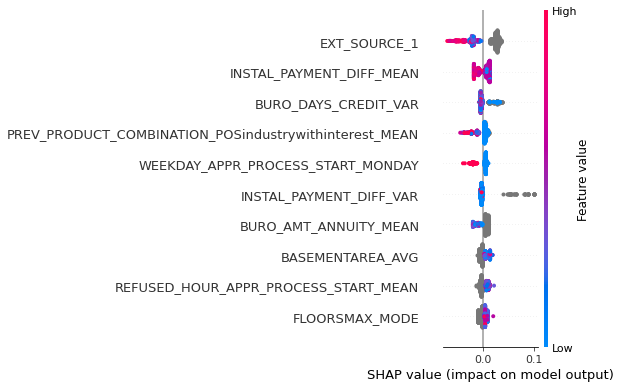

In [11]:
shap.summary_plot(shap_values, X, max_display=max_display)

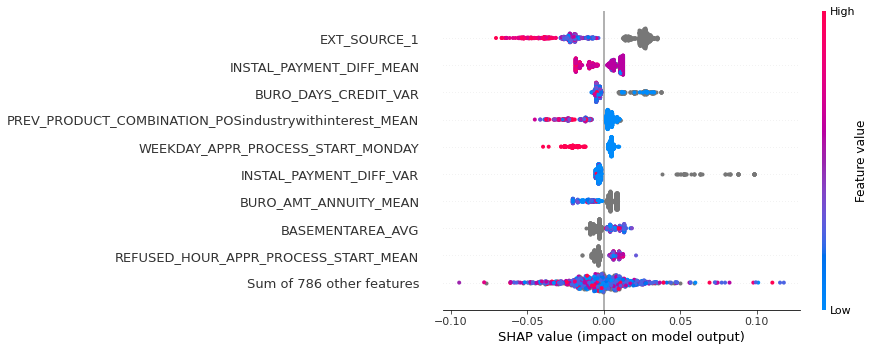

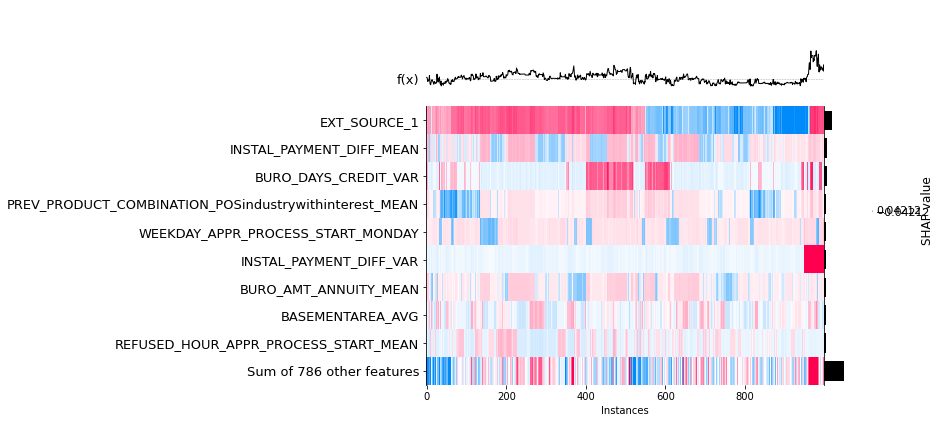

In [12]:
## Summarize the effects of all the features

shap.plots.beeswarm(shap_values, max_display=max_display)
shap.plots.heatmap(shap_values[:1000], max_display=max_display)

### SHAP values plot

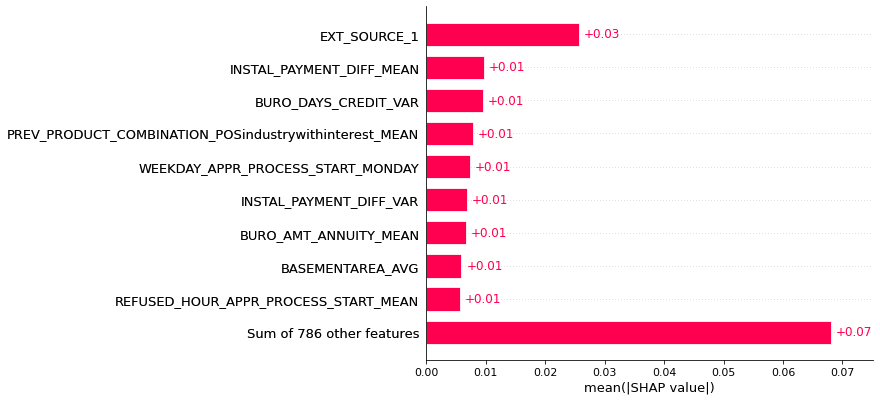

In [13]:
shap.plots.bar(shap_values)

### SHAP Dependence Plots

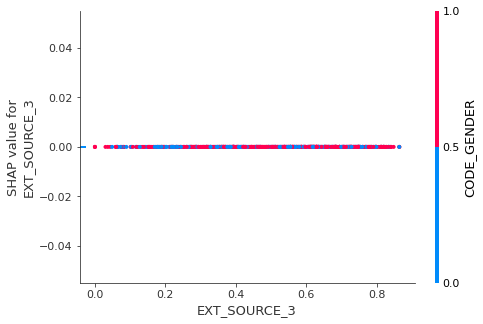

In [14]:
shap.dependence_plot("EXT_SOURCE_3", shap_values_, X)

### Compute SHAP Interaction Values

In [15]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker
shap_interaction_values = shap.TreeExplainer(LGB_clf).shap_interaction_values(X.iloc[:2000,:])

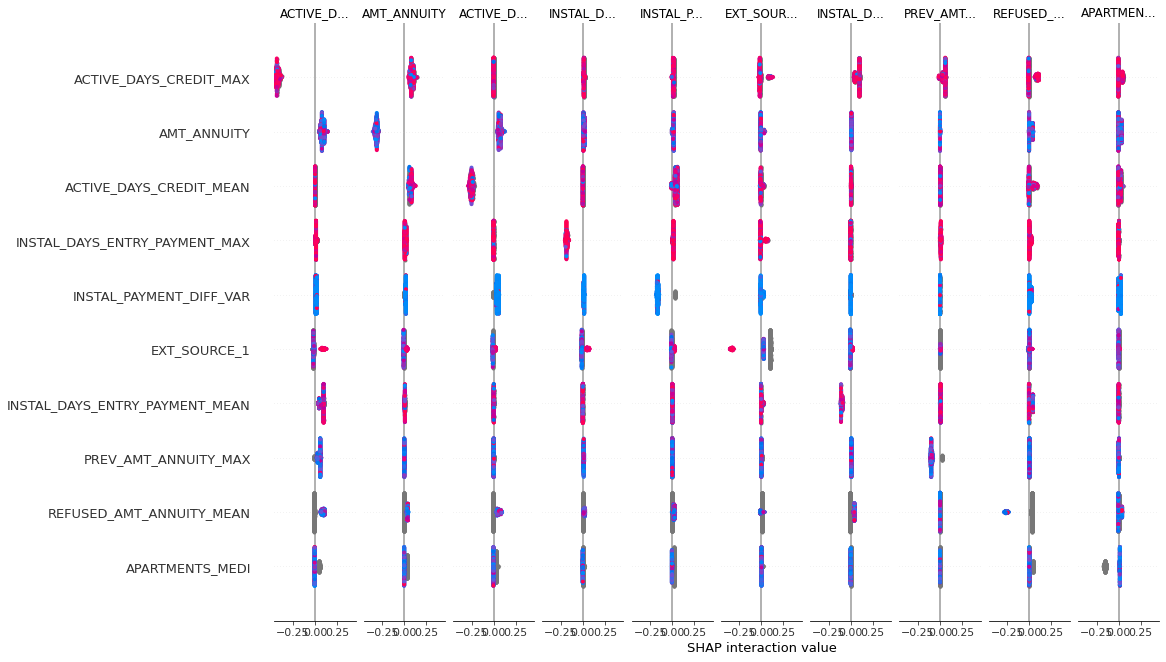

In [16]:
shap.summary_plot(shap_interaction_values, X.iloc[:2000,:], max_display=max_display)

### SHAP Interaction Value Dependence Plots

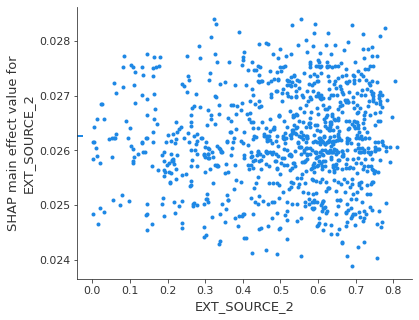

In [17]:
shap.dependence_plot(
    ("EXT_SOURCE_2", "EXT_SOURCE_2"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X.iloc[:2000,:]
)

ValueError: Could not find feature named: OCCUPATION_TYPE_Core staff

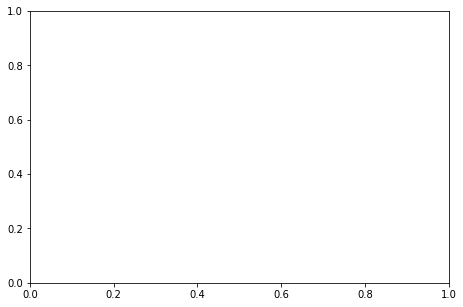

In [18]:
shap.dependence_plot(
    ("EXT_SOURCE_2", "OCCUPATION_TYPE_Core staff"), 
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X.iloc[:2000,:]
)

### Shap Waterfall

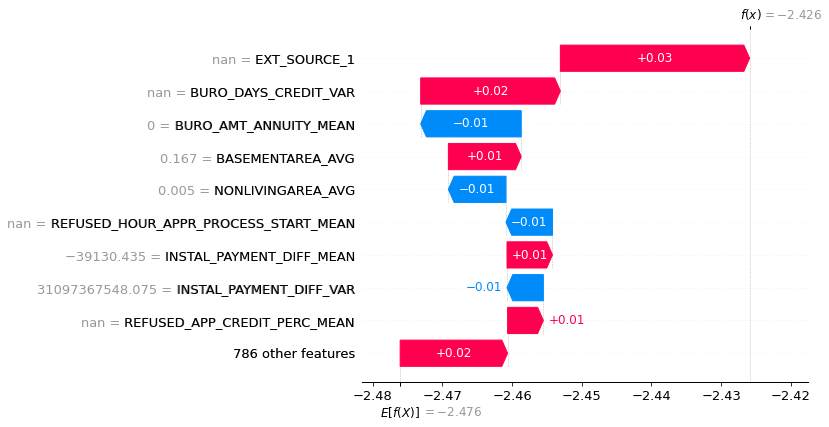

In [19]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=max_display)

### Dependance scatter plot

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"AVG_EXT"], color=shap_values)

In [ ]:
shap.plots.scatter(shap_values[:,"AVG_EXT"], color=shap_values[:,"COMMONAREA_MODE"])

In [ ]:
shap.partial_dependence_plot(
    "EXT_SOURCE_2", LGB_clf.predict, X, ice=False,
    model_expected_value=True, feature_expected_value=True
)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')
    
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TYPE']=='TRAIN']
    test_df = df[df['TYPE']=='TEST']
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [ ]:
debug = True

num_rows = 50000 if debug else None

train_df = pd.read_csv('data/global_train_data.csv', nrows = num_rows) 
test_df = pd.read_csv('data/global_test_data.csv', nrows = num_rows) 
with timer("Run LightGBM with kfold"):
    train_df = train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    feat_importance = kfold_lightgbm(train_df, test_df, num_folds= 10, stratified= False, debug= True)

## LIME